
**Install requirements**

In [1]:
!pip3 install 'torch==1.3.1'
!pip3 install 'torchvision==0.4.2'
!pip3 install 'Pillow-SIMD'
!pip3 install 'tqdm'

**Import libraries**

In [0]:
import os
import os.path
import sys
import logging
import copy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn
from torchvision.datasets import VisionDataset

import torchvision
from torchvision import transforms
from torchvision.models import alexnet
from torchvision.models import resnet50
from torchvision.models import vgg16

from PIL import Image
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Set Arguments**

In [0]:
DEVICE = 'cuda' # 'cuda' or 'cpu'
CNN = 'AlexNet_pretrained' # 'AlexNet' or 'AlexNet_pretrained' or 'ResNet-50' or 'VGG-16'

NUM_CLASSES = 101 # 101 + 1: There is am extra Background class that should be removed 

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-2            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 30      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 10       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

**Define Caltech Dataset class**

In [0]:
def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')


class Caltech(VisionDataset):

    def __init__(self, root, split='train', transform=None, target_transform=None):
        super(Caltech, self).__init__(root, transform=transform, target_transform=target_transform)

        # List of all classes, excluding 'BACKGROUND_Google' class
        self.classes = [d for d in os.listdir(root)
                        if os.path.isdir(os.path.join(root, d))
                        and d != 'BACKGROUND_Google']
        self.classes.sort()

        # Map classes to indexes
        self.class_to_idx = {self.classes[i]: i for i in range(len(self.classes))}

        # Map label to image name, read from txt split file (excluding 'BACKGROUND_Google' class)
        lab_to_image = pd.read_csv('Homework2-Caltech101/{}.txt'.format(split), 
                                   sep='/', header=None, names=['label', 'image'])
        lab_to_image = lab_to_image.loc[lab_to_image['label'] != 'BACKGROUND_Google']

        # List of pair (image, label)
        self.samples = []

        for i, row in lab_to_image.iterrows():
            path = os.path.join(root, row['label'], row['image'])
            if os.path.isfile(path):
                #item = (path, self.class_to_idx[row['label']]) # Use only path to save ram
                item = (pil_loader(path), self.class_to_idx[row['label']])  # Use image to be faster
                self.samples.append(item)

    def __getitem__(self, index):
        '''
        __getitem__ should access an element through its index
        Args:
            index (int): Index
        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        '''

        image, label= self.samples[index] # if image is used in __init__
        #path, label= self.samples[index] # if path is used in __init__
        #image = pil_loader(path)

        # Applies preprocessing when accessing the image
        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def __len__(self):
        '''
        The __len__ method returns the length of the dataset
        It is mandatory, as this is used by several other components
        '''
        return len(self.samples)

**Define Data Preprocessing**

In [0]:
# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      #transforms.RandomHorizontalFlip(),  # Horizontally flip the given PIL Image randomly with a given probability
                                      #transforms.RandomRotation(15),      # Rotate the image by angle
                                      #transforms.RandomPerspective(distortion_scale=0.4), # Performs Perspective transformation of the given PIL Image randomly with a given probability.
                                      #transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),  # Randomly change the brightness, contrast and saturation of an image
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # Normalizes tensor with mean and standard deviation
                                      #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalizes tensor with mean and standard deviation
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))                                    
                                      #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                                    
])

**Prepare Dataset**

In [6]:
# Clone github repository with data
if not os.path.isdir('./Homework2-Caltech101'):
  !git clone https://github.com/MachineLearning2020/Homework2-Caltech101.git

DATA_DIR = 'Homework2-Caltech101/101_ObjectCategories'

# Prepare Pytorch train/test Datasets
train_dataset = Caltech(root=DATA_DIR, split='train', transform=train_transform)
test_dataset = Caltech(root=DATA_DIR, split='test', transform=eval_transform)

# Considering even and odd ensure to both splits about half of images of each class 
train_indexes = [idx for idx in range(len(train_dataset)) if idx % 2]
val_indexes = [idx for idx in range(len(train_dataset)) if not idx % 2]

val_dataset = Subset(train_dataset, val_indexes)
train_dataset = Subset(train_dataset, train_indexes)

# Check dataset sizes
print('Train Dataset: {}'.format(len(train_dataset)))
print('Validation Dataset: {}'.format(len(val_dataset)))
print('Test Dataset: {}'.format(len(test_dataset)))

Train Dataset: 2892
Validation Dataset: 2892
Test Dataset: 2893


**Prepare Dataloaders**

In [0]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

**Prepare Network**

In [0]:
if CNN == 'AlexNet':
  net = alexnet() # Loading AlexNet model
  # AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
  # We need 101 outputs for Caltech-101
  net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                   # The convolutional layer is nn.Conv2d
  # We just changed the last layer of AlexNet with a new fully connected layer with 101 outputs

elif CNN == 'AlexNet_pretrained':
  net = alexnet(pretrained=True) # Loading AlexNet model (pretrained on ImageNet)
  net.classifier[6] = nn.Linear(4096, NUM_CLASSES)  # Changed the last layer of AlexNet

elif CNN == 'ResNet-50':
  net = resnet50(pretrained=True) # Loading ResNet-50 model (pretrained on ImageNet)
  net.fc = nn.Linear(2048, NUM_CLASSES) # Changed the last layer of ResNet-50

else:
  net = vgg16(pretrained=True) # Loading VGG-16 model (pretrained on ImageNet)
  net.classifier[6] = nn.Linear(4096, NUM_CLASSES)  # Changed the last layer of VGG-16

**Prepare Training**

In [0]:
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: net.features.parameters()
#parameters_to_optimize = net.features.parameters() # In this case we optimize over the convolutional layers parameters of AlexNet
#parameters_to_optimize = net.classifier.parameters() # In this case we optimize over the fully connected layers parameters of AlexNet
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

**Define utility function**

In [0]:
def plot_loss_accuracy_trend(loss_values, accuracy_values):
    
  plt.figure(figsize=(15,5))
  
  plt.subplot(1, 2, 1)
  
  epochs = np.arange(1, NUM_EPOCHS+1)

  plt.plot(epochs, loss_values[0], label="Training")
  plt.plot(epochs, loss_values[1], label="Validation")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.title("Loss")
  plt.grid(True)
  plt.legend()
  
  plt.subplot(1, 2, 2)

  plt.plot(epochs, accuracy_values[0], label="Training")
  plt.plot(epochs, accuracy_values[1], label="Validation")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.title("Accuracy")
  plt.grid(True)
  plt.legend()

  plt.tight_layout()
  plt.show()

def get_accuracy(model, dataLoader):
  net = model.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
  net.train(False) # Set Network to evaluation mode

  running_corrects = 0
  for images, labels in dataLoader:
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    # Forward Pass
    outputs = net(images)

    # Get predictions
    _, preds = torch.max(outputs.data, 1)

    # Update Corrects
    running_corrects += torch.sum(preds == labels.data).data.item()

  # Calculate and return Accuracy
  return running_corrects / float(len(test_dataset))

**Train**

Starting epoch 1/30, LR = [0.01]
Step 0, Loss 4.877359390258789
Step 10, Loss 2.132380485534668
Test Accuracy on Validation: 0.6033886583679114
Starting epoch 2/30, LR = [0.01]
Step 20, Loss 0.7919418215751648
Test Accuracy on Validation: 0.7731673582295989
Starting epoch 3/30, LR = [0.01]
Step 30, Loss 0.4811289608478546
Test Accuracy on Validation: 0.8049792531120332
Starting epoch 4/30, LR = [0.01]
Step 40, Loss 0.1830156147480011
Test Accuracy on Validation: 0.8167358229598893
Starting epoch 5/30, LR = [0.01]
Step 50, Loss 0.136893630027771
Test Accuracy on Validation: 0.813969571230982
Starting epoch 6/30, LR = [0.01]
Step 60, Loss 0.05497375503182411
Test Accuracy on Validation: 0.8343706777316736
Starting epoch 7/30, LR = [0.01]
Step 70, Loss 0.027134735137224197
Test Accuracy on Validation: 0.8343706777316736
Starting epoch 8/30, LR = [0.01]
Step 80, Loss 0.037029657512903214
Test Accuracy on Validation: 0.8399031811894883
Starting epoch 9/30, LR = [0.01]
Step 90, Loss 0.018403

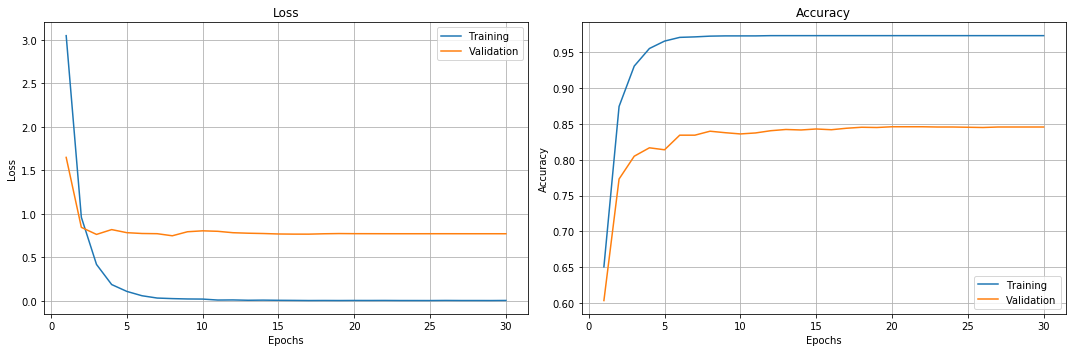

In [11]:
# By default, everything is loaded to cpu
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

cudnn.benchmark # Calling this optimizes runtime

best_net = None
best_accuracy = 0.0

train_acc = []
val_acc = []
train_loss = []
val_loss = []

current_step = 0
# Start iterating over the epochs
for epoch in range(NUM_EPOCHS): 
  print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))

  running_loss = 0.0 
  # Iterate over the dataset
  for images, labels in train_dataloader:
    # Bring data over the device of choice
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    net.train() # Sets module in training mode

    # PyTorch, by default, accumulates gradients after each backward pass
    # We need to manually set the gradients to zero before starting a new iteration
    optimizer.zero_grad() # Zero-ing the gradients

    # Forward pass to the network
    outputs = net(images)

    # Compute loss based on output and ground truth
    loss = criterion(outputs, labels)
    running_loss += loss.item() 
    
    # Log loss
    if current_step % LOG_FREQUENCY == 0:
      print('Step {}, Loss {}'.format(current_step, loss.item()))

    # Compute gradients for each layer and update weights
    loss.backward()  # backward pass: computes gradients
    optimizer.step() # update weights based on accumulated gradients

    current_step += 1
  
  train_loss.append(running_loss/len(train_dataloader))  # compute average loss
  train_acc.append(get_accuracy(net, train_dataloader)) # compute accuracy on train set

  # Evaluate the model on the validation set
  net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
  net.train(False) # Set Network to evaluation mode
  
  # Change transforms to apply on validation data
  val_dataloader.dataset.dataset.transform = eval_transform
  
  running_loss = 0.0  
  running_corrects = 0
  for images, labels in val_dataloader:
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    # Forward Pass
    outputs = net(images)
    
    # Compute loss based on output and ground truth
    loss = criterion(outputs, labels)
    running_loss += loss.item()
    
    # Get predictions
    _, preds = torch.max(outputs.data, 1)

    # Update Corrects
    running_corrects += torch.sum(preds == labels.data).data.item()

  # Calculate Accuracy
  accuracy = running_corrects / float(len(val_dataset))

  print('Test Accuracy on Validation: {}'.format(accuracy))
  
  # Update the best model
  if accuracy > best_accuracy:
    best_accuracy = accuracy
    best_net = copy.deepcopy(net)
  
  val_acc.append(accuracy)
  val_loss.append(running_loss/len(val_dataloader))
  
  # Change transforms to apply on train data
  train_dataloader.dataset.dataset.transform = train_transform
  # Step the scheduler
  scheduler.step() 

# Plot loss and accuracy trend
plot_loss_accuracy_trend([train_loss, val_loss], [train_acc, val_acc])

**Test**

In [12]:
best_net = best_net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
best_net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(test_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = best_net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(test_dataset))

print('Test Accuracy: {}'.format(accuracy))
print('Best Accuracy on Validation: {}'.format(best_accuracy))

100%|██████████| 12/12 [00:09<00:00,  1.31it/s]

Test Accuracy: 0.8503283788454891
Best Accuracy on Validation: 0.8461272475795297
